In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

In [2]:
df = pd.read_csv('german_credit_data.csv', index_col=0)

In [3]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


# Смотрим структуру и пропуски

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


### Получается 2 фичи с пропусками

In [5]:
columns_with_nan = ['Saving accounts', 'Checking account']

In [6]:
sa_missing_procent = 100 * df['Saving accounts'].isna().sum() / len(df)
ca_missing_procent = 100 * df['Checking account'].isna().sum() / len(df)

print(f'percent of missing in "Saving accounts" {sa_missing_procent}')
print(f'percent of missing in "Checking account" {ca_missing_procent}')

percent of missing in "Saving accounts" 18.3
percent of missing in "Checking account" 39.4


In [7]:
#### Слишком много пропусков и обе фичи категориальные, можно заменить пропуски на "unknown"

In [8]:
df['Saving accounts'].fillna('unknown', inplace=True)
df['Saving accounts'].value_counts()

little        603
unknown       183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

In [9]:
df['Checking account'].fillna('unknown', inplace=True)
df['Checking account'].value_counts()

unknown     394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

In [10]:
df.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       5
Checking account      4
Credit amount       921
Duration             33
Purpose               8
dtype: int64

### Разделим категориальные и числовые фичи

In [11]:
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 
                        'Checking account', 'Purpose']

numeric_features = ['Age', 'Credit amount', 'Duration']

# EDA

<AxesSubplot:xlabel='Sex', ylabel='count'>

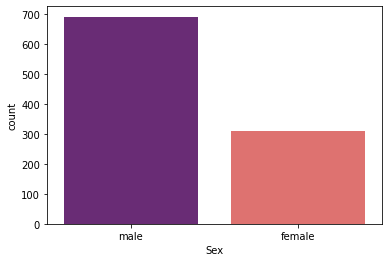

In [12]:
sns.countplot(x='Sex', data=df, palette='magma')

#### Мужчины в 2 раза чаще берут кредит

In [13]:
df[numeric_features].describe()

,Age,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000
std,11.375469,2822.736876,12.058814
min,19.000000,250.000000,4.000000
25%,27.000000,1365.500000,12.000000
50%,33.000000,2319.500000,18.000000
75%,42.000000,3972.250000,24.000000
max,75.000000,18424.000000,72.000000


<AxesSubplot:xlabel='Age', ylabel='Duration'>

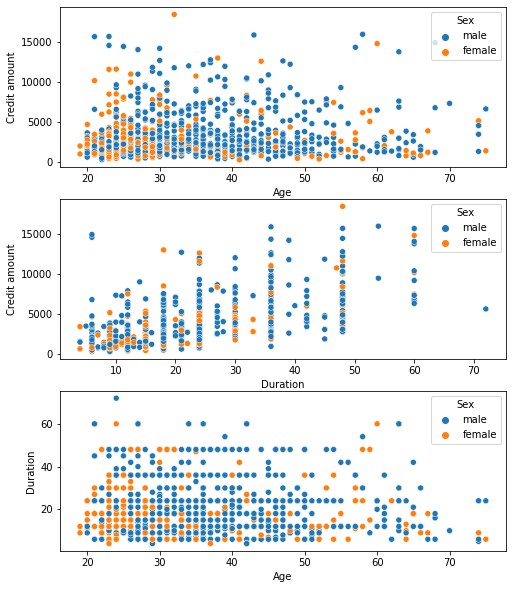

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
sns.scatterplot(x='Age', y='Credit amount', hue='Sex', data=df, ax=axes[0])
sns.scatterplot(x='Duration', y='Credit amount', hue='Sex', data=df, ax=axes[1])
sns.scatterplot(x='Age', y='Duration', hue='Sex', data=df, ax=axes[2])

#### Можно заметить что женщины берут кредиты в более молодом возрасте, так же видна линейная зависимость между размером кредита и длительностью.

               Duration  Credit amount
Duration       1.000000       0.624984
Credit amount  0.624984       1.000000


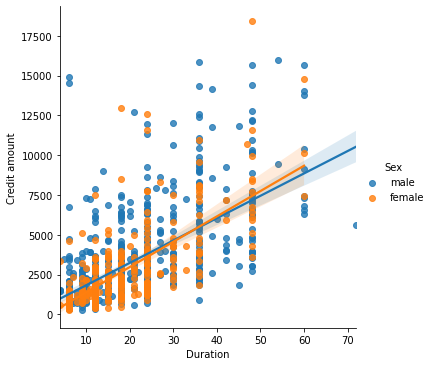

In [15]:
reg = sns.lmplot(x='Duration', y='Credit amount', hue='Sex', data=df)
print(df[['Duration', 'Credit amount']].corr())

### 3d график числовых переменных

In [16]:
%matplotlib widget

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df['Duration']
y = df['Credit amount']
z = df['Age']

ax.set_xlabel('Duration')
ax.set_ylabel('Credit amount')
ax.set_zlabel('Age')

c = list(df['Sex'].apply(lambda x: 0 if x == 'male' else 1))
cmhot = plt.get_cmap("bwr")
ax.scatter(x, y, z, c=c, cmap=cmhot, s=8)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### Можно сделать вывод, что в целом люди чаще бурут не длительные кредиты и на небольшие суммы

In [18]:
%matplotlib inline

### Посмотрим на распределения и что будет если их прологарифмировать

Text(0.5, 0, 'Duration')

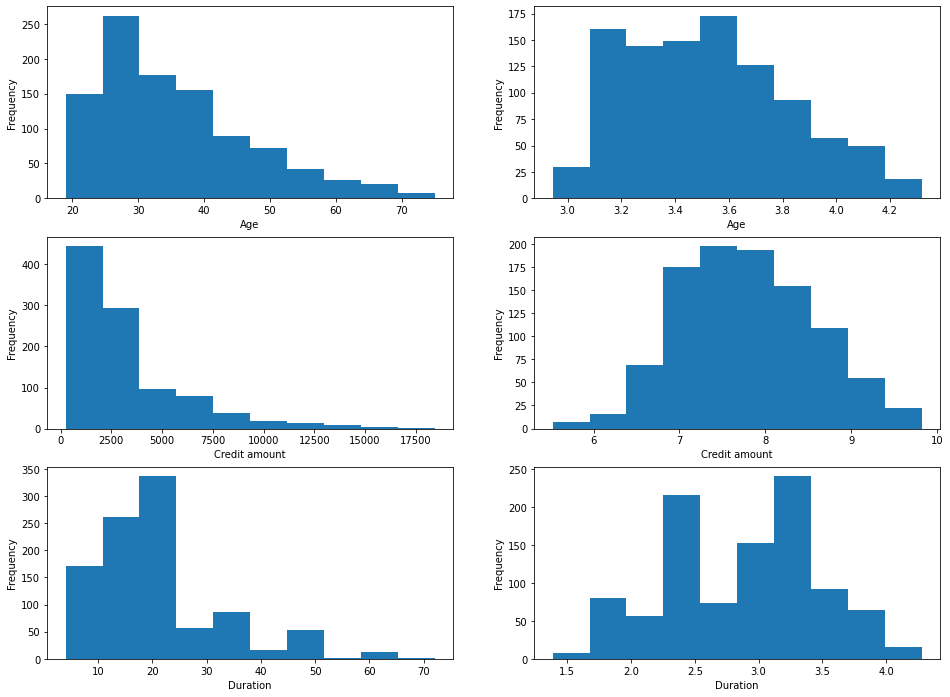

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

df['Age'].plot.hist(ax=axes[0, 0])
np.log(df['Age']).plot.hist(ax=axes[0, 1])
axes[0, 0].set_xlabel('Age')
axes[0, 1].set_xlabel('Age')

df['Credit amount'].plot.hist(ax=axes[1, 0])
np.log(df['Credit amount']).plot.hist(ax=axes[1, 1])
axes[1, 0].set_xlabel('Credit amount')
axes[1, 1].set_xlabel('Credit amount')

df['Duration'].plot.hist(ax=axes[2, 0])
np.log(df['Duration']).plot.hist(ax=axes[2, 1])
axes[2, 0].set_xlabel('Duration')
axes[2, 1].set_xlabel('Duration')

#### Можно сказать, что логарифмирование приблизило все варианты к нормальному распределению

In [20]:
df['age_log'] = np.log(df['Age'])
df['credit_amount_log'] = np.log(df['Credit amount'])
df['duration_log'] = np.log(df['Duration'])

### Проверим поле Purpose

In [21]:
df['Purpose'].value_counts(normalize=True)

car                    0.337
radio/TV               0.280
furniture/equipment    0.181
business               0.097
education              0.059
repairs                0.022
vacation/others        0.012
domestic appliances    0.012
Name: Purpose, dtype: float64

<AxesSubplot:xlabel='Purpose', ylabel='Count'>

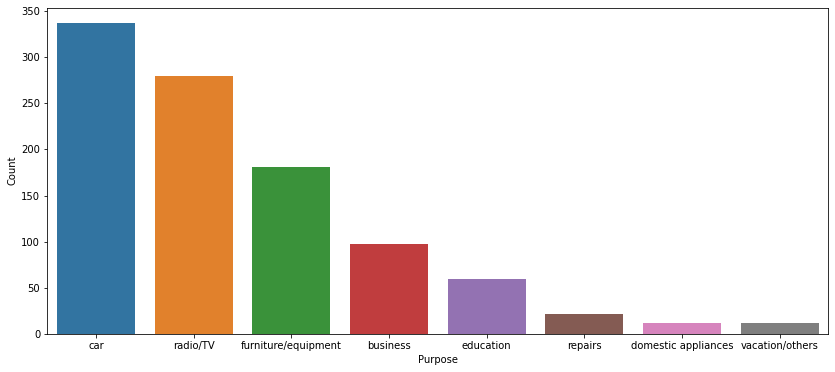

In [22]:
fig = plt.figure(figsize=(14, 6))
credits_purpose = df.groupby('Purpose')[['Age']].count().reset_index().rename(columns={'Age': 'Count'}).sort_values('Count', ascending=False)
sns.barplot(x='Purpose', y='Count', data=credits_purpose)

<AxesSubplot:xlabel='Purpose', ylabel='Credit amount'>

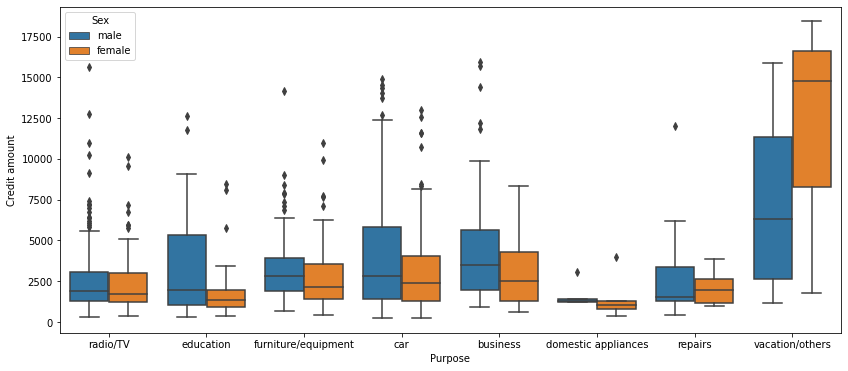

In [23]:
fig = plt.figure(figsize=(14, 6))
sns.boxplot(x='Purpose', y='Credit amount', data=df, hue='Sex')

<AxesSubplot:xlabel='Purpose', ylabel='Duration'>

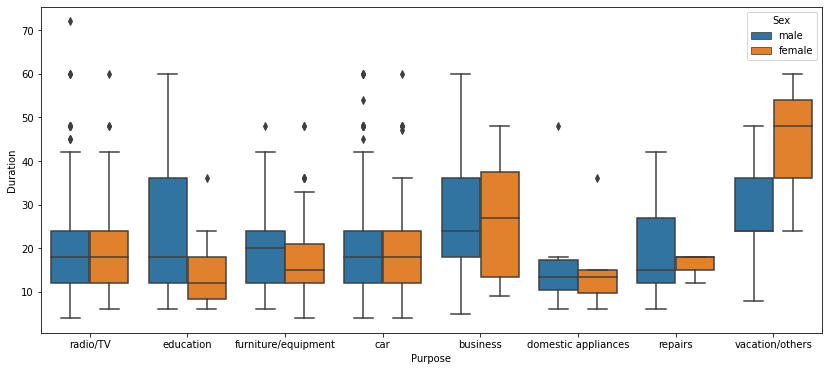

In [24]:
fig = plt.figure(figsize=(14, 6))
sns.boxplot(x='Purpose', y='Duration', data=df, hue='Sex')

<AxesSubplot:xlabel='Purpose', ylabel='Age'>

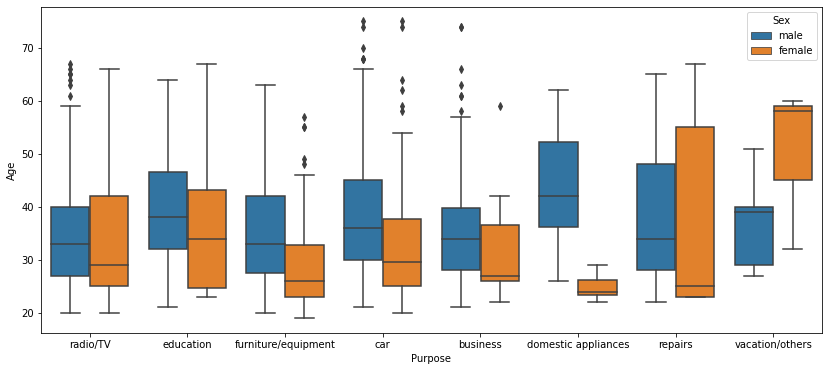

In [25]:
fig = plt.figure(figsize=(14, 6))
sns.boxplot(x='Purpose', y='Age', data=df, hue='Sex')

#### На последнюю категорию как правило берут большие сумму и на долго (причем судя по последнему графику женщины предпочитают брать такие кредиты в пожилом возрасте, а мужчины в среднем), а вот на бытовую технику наоборот, немного и не на долго (только тут уже женщины в молодости, а мужчины в зрелости)

<AxesSubplot:xlabel='Purpose', ylabel='Credit amount'>

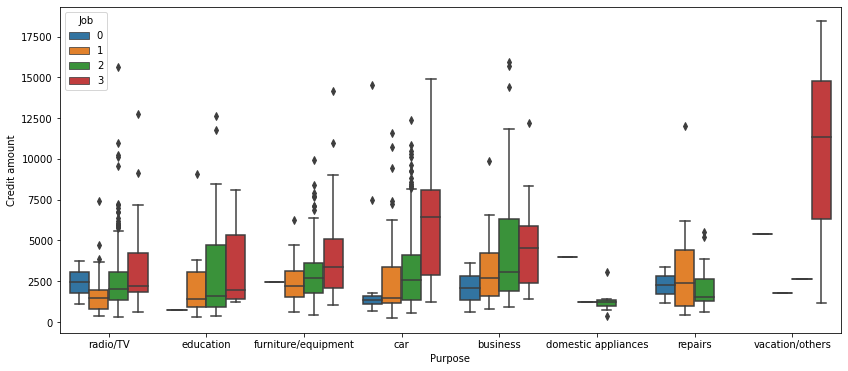

In [26]:
fig = plt.figure(figsize=(14, 6))
sns.boxplot(x='Purpose', y='Credit amount', data=df, hue='Job')

<AxesSubplot:xlabel='Housing', ylabel='Credit amount'>

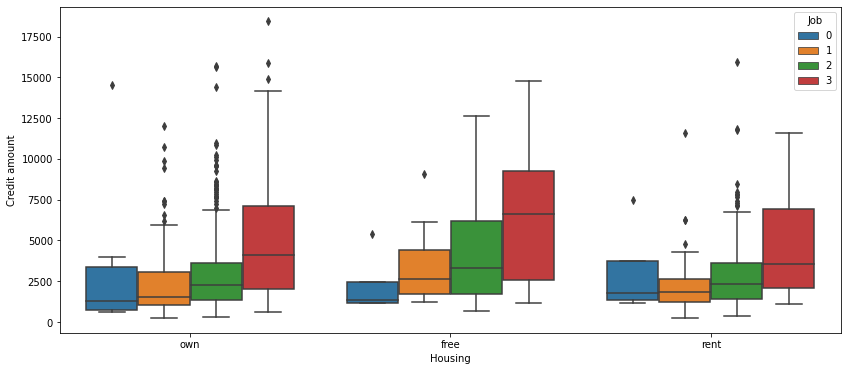

In [27]:
fig = plt.figure(figsize=(14, 6))
sns.boxplot(x='Housing', y='Credit amount', data=df, hue='Job')

#### Как и ожидалось, люди с хорошей работой и своим либо бесплатным жилищем берут кредиты на большие суммы

### Закодируем категориальные признаки

In [28]:
data = pd.get_dummies(columns=['Sex', 'Job', 'Housing',
                               'Purpose', 'Saving accounts',
                               'Checking account'], data=df).drop(columns=['Credit amount', 'Age','Duration'])

In [29]:
data.head()

,age_log,credit_amount_log,duration_log,Sex_female,Sex_male,Job_0,Job_1,Job_2,Job_3,Housing_free,...,Purpose_vacation/others,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Saving accounts_unknown,Checking account_little,Checking account_moderate,Checking account_rich,Checking account_unknown
0,4.204693,7.063904,1.791759,0,1,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
1,3.091042,8.691315,3.871201,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,3.891820,7.647786,2.484907,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,3.806662,8.972337,3.737670,0,1,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0
4,3.970292,8.490849,3.178054,0,1,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0


## Scaling

In [30]:
scaler = StandardScaler()
data_scaled = data.copy()
data_scaled[['age_log', 'credit_amount_log', 'duration_log']] = scaler.fit_transform(data[['age_log', 'credit_amount_log', 'duration_log']])

In [31]:
data_scaled.head()

,age_log,credit_amount_log,duration_log,Sex_female,Sex_male,Job_0,Job_1,Job_2,Job_3,Housing_free,...,Purpose_vacation/others,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Saving accounts_unknown,Checking account_little,Checking account_moderate,Checking account_rich,Checking account_unknown
0,2.271006,-0.933901,-1.864869,0,1,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
1,-1.446152,1.163046,1.708369,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,1.226696,-0.181559,-0.673790,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0.942455,1.525148,1.478913,0,1,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0
4,1.488620,0.904743,0.517289,0,1,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0


### PCA

In [32]:
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_scaled)
data_2d = pd.DataFrame(data_2d, columns=['P1', 'P2'])

In [33]:
data_2d.head()

,P1,P2
0,1.926507,2.307628
1,-1.882924,-1.792143
2,0.700397,1.432041
3,-2.200118,0.819857
4,-1.132165,1.528176


<AxesSubplot:xlabel='P1', ylabel='P2'>

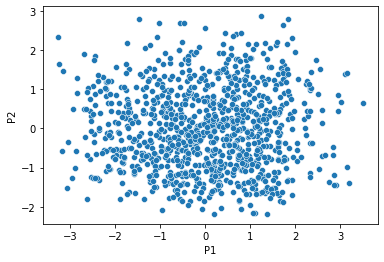

In [34]:
sns.scatterplot(x='P1', y='P2', data=data_2d, palette='rainbow')

# Кластеризация

### Silhouette coef

In [42]:
def get_silhouette(algo, algo_range, feature_to_change):
    silhouette = []
    clusters = []
    for i in algo_range:
        clusterization = algo(**{feature_to_change: i}).fit(data_scaled)
        if isinstance(clusterization, GaussianMixture):
            labels = clusterization.predict(data_scaled)
        else:
            labels = clusterization.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(data_scaled, labels)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)
    return silhouette, clusters

## Kmeans

### Возьмем прологарифмированные числовые коэффициенты

In [36]:
n_clusters_range = range(1, 15)
inertia_list = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data_scaled)
    inertia_list.append(kmeans.inertia_)

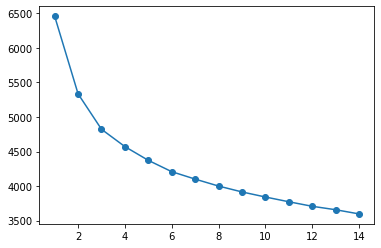

In [37]:
plt.plot(n_clusters_range, inertia_list, marker='o')

In [38]:
d = []
for i in range(1, 13):
    di = (inertia_list[i] - inertia_list[i+1]) / (inertia_list[i-1] - inertia_list[i])
    d.append(di)

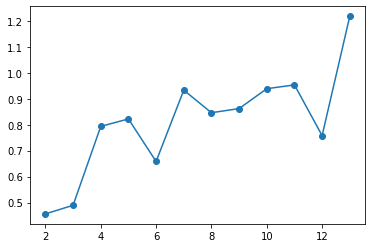

In [39]:
plt.plot(range(2, 14), d, marker='o')

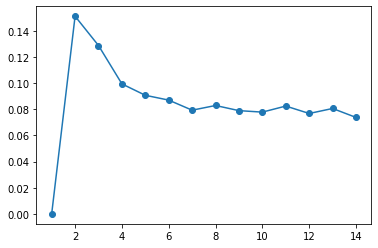

In [43]:
feature_range = range(1, 15)
silhouette, clusters = get_silhouette(KMeans, feature_range, 'n_clusters')
plt.plot(feature_range, silhouette, marker='o')

### Опитимально будет взять 2, 3 и 6 кластеров

#### 2 кластера

In [44]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(data_scaled)
labels = kmeans.labels_

<AxesSubplot:xlabel='P1', ylabel='P2'>

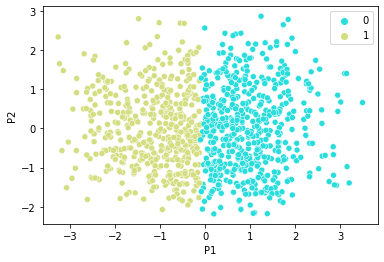

In [45]:
# Уменьшенная размерность

%matplotlib inline

sns.scatterplot(x='P1', y='P2', data=data_2d, hue=labels, palette='rainbow')

<AxesSubplot:xlabel='Age', ylabel='Credit amount'>

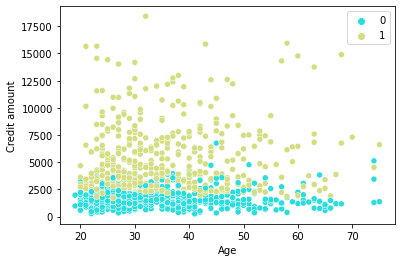

In [46]:
fig = plt.figure()
sns.scatterplot(x='Age', y='Credit amount', data=df, hue=labels, palette='rainbow')

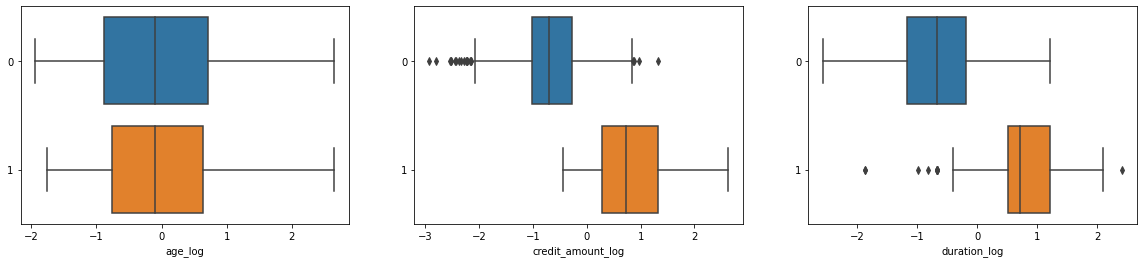

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax_index, col in enumerate(['age_log', 'credit_amount_log', 'duration_log']):
    sns.boxplot(data=data_scaled, x=col, y=labels, orient='h', ax=axes[ax_index])

In [48]:
# Функция для отрисовки 3д графика на оригинальных данных
def plot_3d_on_original_data(new_labels):
    %matplotlib widget

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = df['Duration']
    y = df['Credit amount']
    z = df['Age']

    ax.set_xlabel('Duration')
    ax.set_ylabel('Credit amount')
    ax.set_zlabel('Age')

    cmhot = plt.get_cmap("rainbow")
    ax.scatter(x, y, z, c=new_labels, cmap=cmhot, s=8)

    plt.show()
    
# Функция для отрисовки 3д графика на скалированных данных
def plot_3d_on_scaled_data(new_labels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = data_scaled['duration_log']
    y = data_scaled['credit_amount_log']
    z = data_scaled['age_log']

    ax.set_xlabel('Duration')
    ax.set_ylabel('Credit amount')
    ax.set_zlabel('Age')

    cmhot = plt.get_cmap("rainbow")
    ax.scatter(x, y, z, c=labels, cmap=cmhot, s=8)

    plt.show()

In [50]:
plot_3d_on_original_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [51]:
plot_3d_on_scaled_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [52]:
df['labels'] = labels
df.groupby('labels').median().T.round(2)

labels,0,1
Age,33.00,33.00
Job,2.00,2.00
Credit amount,1410.00,4221.00
Duration,12.00,27.00
age_log,3.50,3.50
credit_amount_log,7.25,8.35
duration_log,2.48,3.30


#### Разбиение на 2 кластера оказалось не не таким уж плохим, на скалированных данных отлично видно различие между кластерами

### 3 кластера

In [53]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(data_scaled)
labels = kmeans.labels_

<AxesSubplot:xlabel='P1', ylabel='P2'>

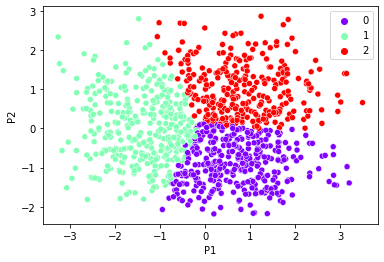

In [54]:
# Уменьшенная размерность

%matplotlib inline

sns.scatterplot(x='P1', y='P2', data=data_2d, hue=labels, palette='rainbow')

<AxesSubplot:xlabel='Age', ylabel='Credit amount'>

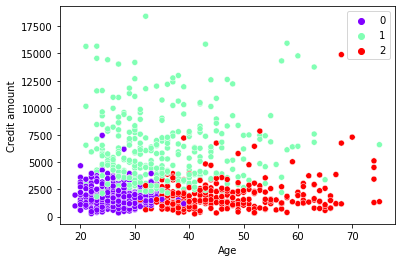

In [55]:
fig = plt.figure()
sns.scatterplot(x='Age', y='Credit amount', data=df, hue=labels, palette='rainbow')

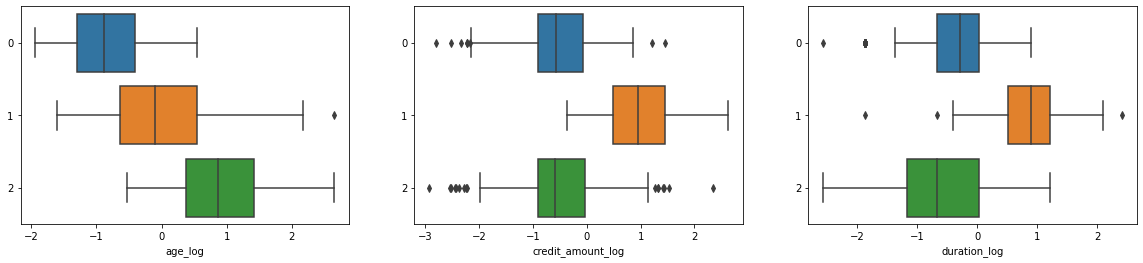

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax_index, col in enumerate(['age_log', 'credit_amount_log', 'duration_log']):
    sns.boxplot(data=data_scaled, x=col, y=labels, orient='h', ax=axes[ax_index])

In [57]:
plot_3d_on_original_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [58]:
plot_3d_on_scaled_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [59]:
df['labels'] = labels
df.groupby('labels').median().T.round(2)

labels,0,1,2
Age,26.00,33.00,44.00
Job,2.00,2.00,2.00
Credit amount,1552.00,5043.50,1538.00
Duration,15.00,30.00,12.00
age_log,3.26,3.50,3.78
credit_amount_log,7.35,8.53,7.34
duration_log,2.71,3.40,2.48


### 6 кластеров

In [60]:
kmeans = KMeans(n_clusters=6, random_state=42).fit(data_scaled)
labels = kmeans.labels_

<AxesSubplot:xlabel='P1', ylabel='P2'>

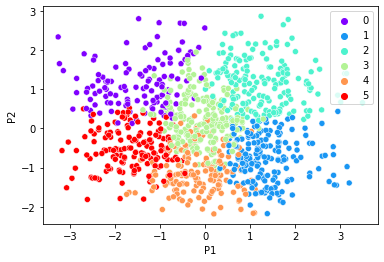

In [61]:
%matplotlib inline
# Уменьшенная размерность
sns.scatterplot(x='P1', y='P2', data=data_2d, hue=labels, palette='rainbow')

<AxesSubplot:xlabel='Age', ylabel='Credit amount'>

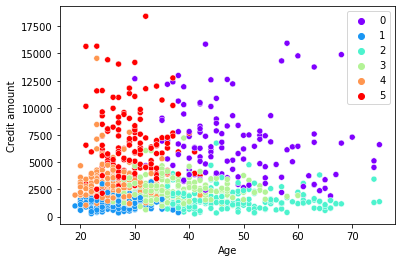

In [62]:
fig = plt.figure()
sns.scatterplot(x='Age', y='Credit amount', data=df, hue=labels, palette='rainbow')

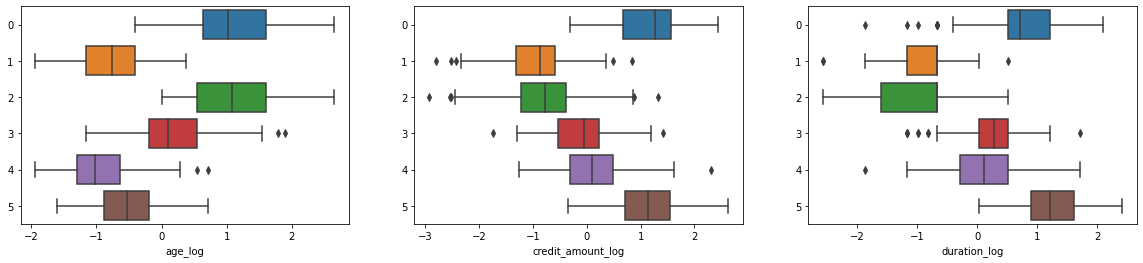

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax_index, col in enumerate(['age_log', 'credit_amount_log', 'duration_log']):
    sns.boxplot(data=data_scaled, x=col, y=labels, orient='h', ax=axes[ax_index])

In [64]:
plot_3d_on_original_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [65]:
plot_3d_on_scaled_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [66]:
df['labels'] = labels
df.groupby('labels').median().T.round(2)

labels,0,1,2,3,4,5
Age,46.00,27.00,47.00,35.00,25.00,29.00
Job,2.00,2.00,2.00,2.00,2.00,2.00
Credit amount,6416.00,1229.50,1320.00,2319.00,2604.50,5857.00
Duration,27.00,12.00,12.00,21.00,19.00,36.00
age_log,3.83,3.30,3.85,3.56,3.22,3.37
credit_amount_log,8.77,7.11,7.19,7.75,7.86,8.68
duration_log,3.30,2.48,2.48,3.04,2.94,3.58


### Во всех случаях Kmeans показал себя с хорошой стороны

## EM алгоритм

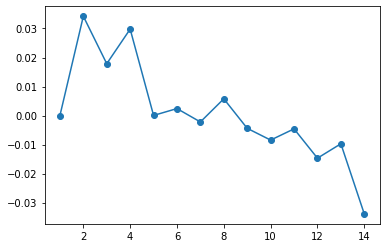

In [67]:
feature_range = range(1, 15)
silhouette, clusters = get_silhouette(GaussianMixture, feature_range, 'n_components')

%matplotlib inline

plt.plot(feature_range, silhouette, marker='o')

### Исходя из силуетного коэффициента, есть смысл взять 2, 3 и 5 кластеров

### 2 кластера

In [68]:
gauss = GaussianMixture(n_components=2, random_state=42).fit(data_scaled)
labels = gauss.predict(data_scaled)

<AxesSubplot:xlabel='P1', ylabel='P2'>

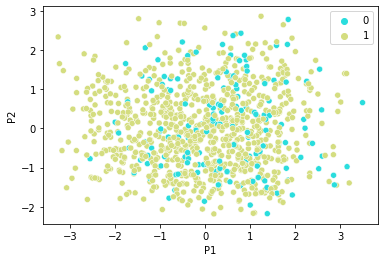

In [69]:
# Уменьшенная размерность

sns.scatterplot(x='P1', y='P2', data=data_2d, hue=labels, palette='rainbow')

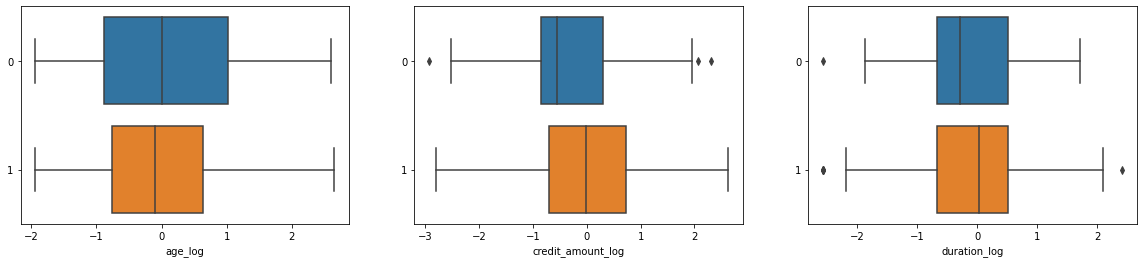

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax_index, col in enumerate(['age_log', 'credit_amount_log', 'duration_log']):
    sns.boxplot(data=data_scaled, x=col, y=labels, orient='h', ax=axes[ax_index])

In [71]:
plot_3d_on_original_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [72]:
plot_3d_on_scaled_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [73]:
df['labels'] = labels
df.groupby('labels').median().T.round(2)

labels,0,1
Age,34.00,33.00
Job,2.00,2.00
Credit amount,1577.00,2397.00
Duration,15.00,18.00
age_log,3.53,3.50
credit_amount_log,7.36,7.78
duration_log,2.71,2.89


### 3 кластера

In [74]:
gauss = GaussianMixture(n_components=3, random_state=42).fit(data_scaled)
labels = gauss.predict(data_scaled)

<AxesSubplot:xlabel='P1', ylabel='P2'>

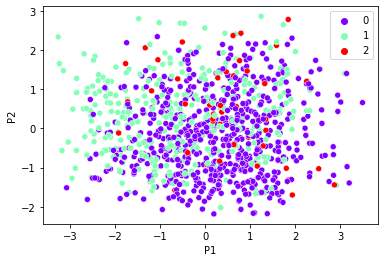

In [75]:
# Уменьшенная размерность

%matplotlib inline

sns.scatterplot(x='P1', y='P2', data=data_2d, hue=labels, palette='rainbow')

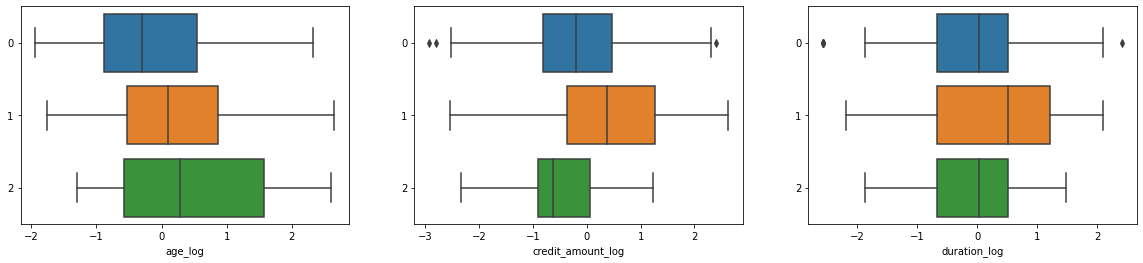

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax_index, col in enumerate(['age_log', 'credit_amount_log', 'duration_log']):
    sns.boxplot(data=data_scaled, x=col, y=labels, orient='h', ax=axes[ax_index])

In [77]:
plot_3d_on_original_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [78]:
plot_3d_on_scaled_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [79]:
df['labels'] = labels
df.groupby('labels').median().T.round(2)

labels,0,1,2
Age,31.00,35.00,37.00
Job,2.00,2.00,2.00
Credit amount,2073.00,3242.00,1474.00
Duration,18.00,24.00,18.00
age_log,3.43,3.56,3.61
credit_amount_log,7.64,8.08,7.30
duration_log,2.89,3.18,2.89


### 5 кластеров

In [80]:
gauss = GaussianMixture(n_components=5, random_state=42).fit(data_scaled)
labels = gauss.predict(data_scaled)

<AxesSubplot:xlabel='P1', ylabel='P2'>

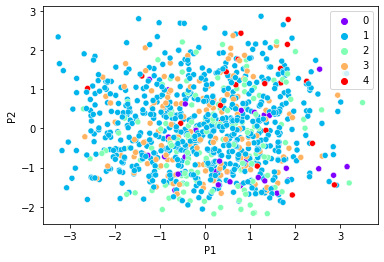

In [81]:
# Уменьшенная размерность

%matplotlib inline

sns.scatterplot(x='P1', y='P2', data=data_2d, hue=labels, palette='rainbow')

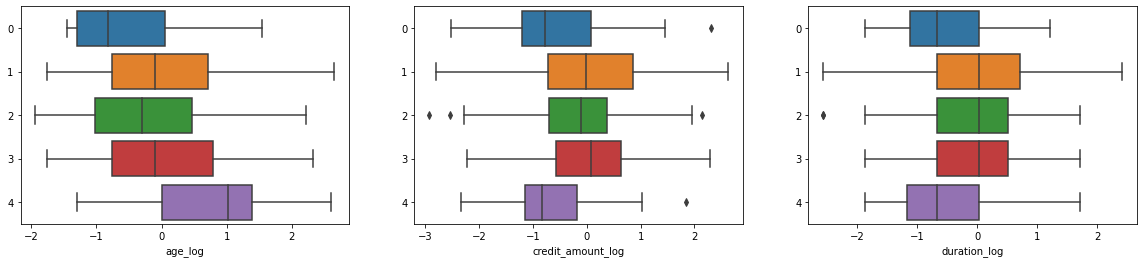

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax_index, col in enumerate(['age_log', 'credit_amount_log', 'duration_log']):
    sns.boxplot(data=data_scaled, x=col, y=labels, orient='h', ax=axes[ax_index])

In [83]:
plot_3d_on_original_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [84]:
plot_3d_on_scaled_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [85]:
df['labels'] = labels
df.groupby('labels').median().T.round(2)

labels,0,1,2,3,4
Age,26.50,33.00,31.00,33.00,46.00
Job,1.00,2.00,2.00,2.00,2.00
Credit amount,1330.00,2386.50,2234.00,2577.00,1262.00
Duration,12.00,18.00,18.00,18.00,12.00
age_log,3.28,3.50,3.43,3.50,3.83
credit_amount_log,7.19,7.78,7.71,7.85,7.14
duration_log,2.48,2.89,2.89,2.89,2.48


### Можно сделать вывод, что EM алгоритм не очень хорошо справляется с этой задачей

## Agglomerative

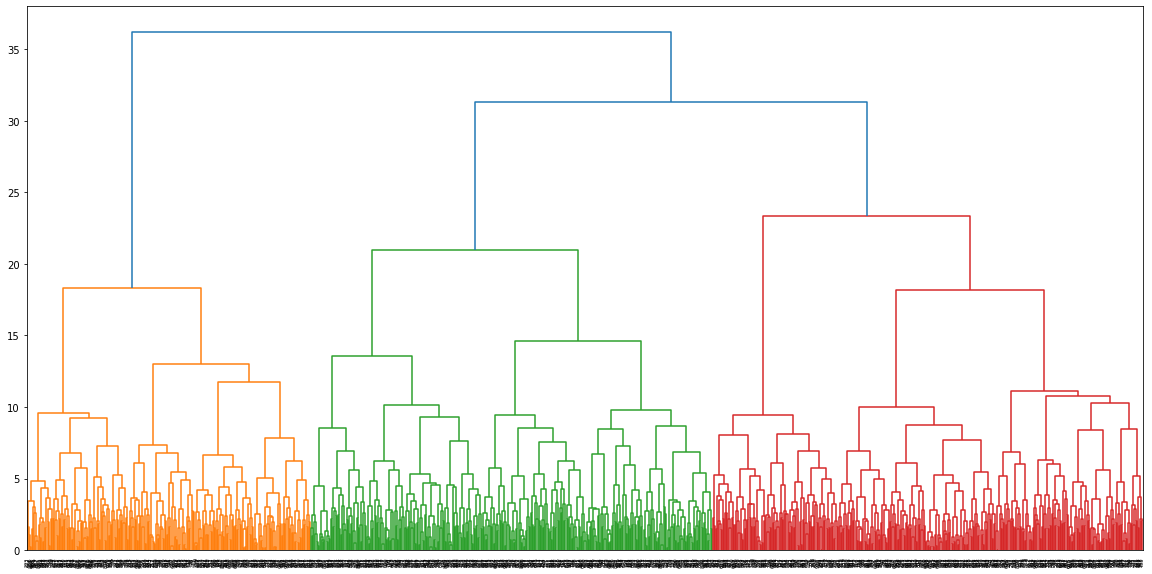

In [86]:
%matplotlib inline

plt.figure(figsize=(20,10))
linkage_ = linkage(data_scaled, method='ward')
dendrogram_ = dendrogram(linkage_)

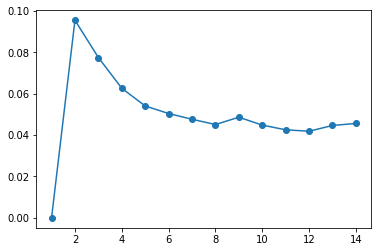

In [87]:
feature_range = range(1, 15)
silhouette, clusters = get_silhouette(AgglomerativeClustering, feature_range, 'n_clusters')
plt.plot(feature_range, silhouette, marker='o')

### Исходя из дендрограммы можно сделать вывод, что оптимальное число кластеров будет 2, 3, 5 и 7 кластеров

### 2 кластера

In [88]:
agg = AgglomerativeClustering(n_clusters=2).fit(data_scaled)
labels = agg.labels_

<AxesSubplot:xlabel='P1', ylabel='P2'>

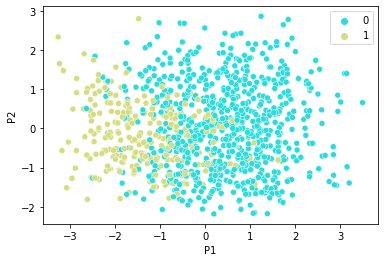

In [89]:
# Уменьшенная размерность

%matplotlib inline

sns.scatterplot(x='P1', y='P2', data=data_2d, hue=labels, palette='rainbow')

<AxesSubplot:xlabel='Age', ylabel='Credit amount'>

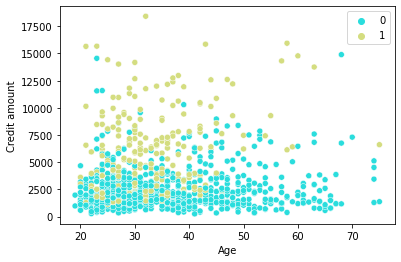

In [90]:
fig = plt.figure()
sns.scatterplot(x='Age', y='Credit amount', data=df, hue=labels, palette='rainbow')

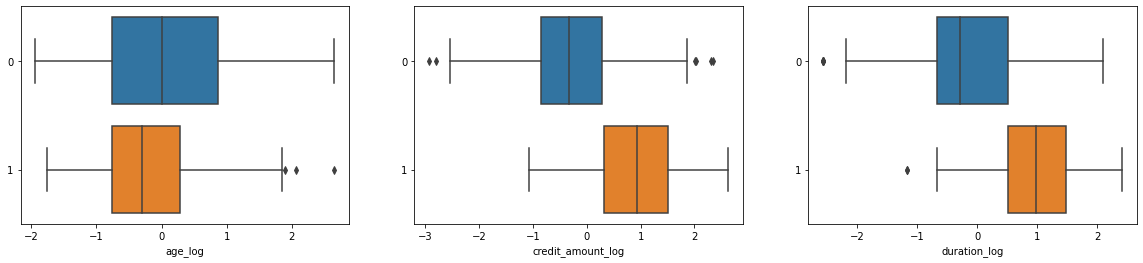

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax_index, col in enumerate(['age_log', 'credit_amount_log', 'duration_log']):
    sns.boxplot(data=data_scaled, x=col, y=labels, orient='h', ax=axes[ax_index])

In [92]:
plot_3d_on_original_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [93]:
plot_3d_on_scaled_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [94]:
df['labels'] = labels
df.groupby('labels').median().T.round(2)

labels,0,1
Age,34.00,31.00
Job,2.00,2.00
Credit amount,1862.00,5014.50
Duration,15.00,31.50
age_log,3.53,3.43
credit_amount_log,7.53,8.52
duration_log,2.71,3.45


### 3 кластера

In [95]:
agg = AgglomerativeClustering(n_clusters=3).fit(data_scaled)
labels = agg.labels_

<AxesSubplot:xlabel='P1', ylabel='P2'>

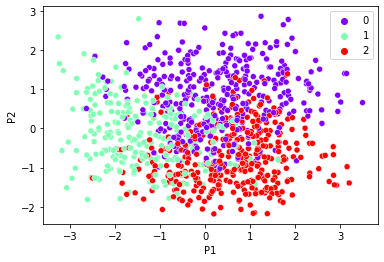

In [96]:
# Уменьшенная размерность

%matplotlib inline

sns.scatterplot(x='P1', y='P2', data=data_2d, hue=labels, palette='rainbow')

<AxesSubplot:xlabel='Age', ylabel='Credit amount'>

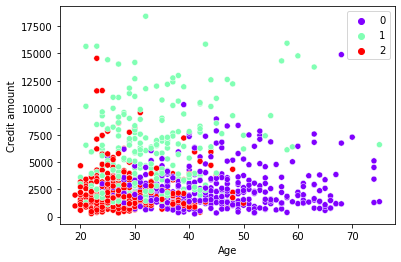

In [97]:
fig = plt.figure()
sns.scatterplot(x='Age', y='Credit amount', data=df, hue=labels, palette='rainbow')

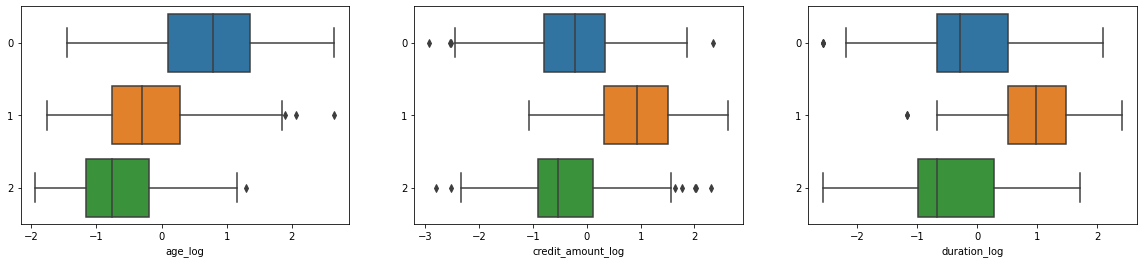

In [98]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax_index, col in enumerate(['age_log', 'credit_amount_log', 'duration_log']):
    sns.boxplot(data=data_scaled, x=col, y=labels, orient='h', ax=axes[ax_index])

In [99]:
plot_3d_on_original_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [100]:
plot_3d_on_scaled_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [101]:
df['labels'] = labels
df.groupby('labels').median().T.round(2)

labels,0,1,2
Age,43.00,31.00,27.00
Job,2.00,2.00,2.00
Credit amount,2030.00,5014.50,1594.50
Duration,15.00,31.50,12.00
age_log,3.76,3.43,3.30
credit_amount_log,7.62,8.52,7.37
duration_log,2.71,3.45,2.48


### 5 кластеров

In [102]:
agg = AgglomerativeClustering(n_clusters=5).fit(data_scaled)
labels = agg.labels_

<AxesSubplot:xlabel='P1', ylabel='P2'>

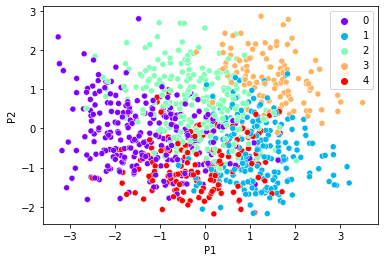

In [103]:
# Уменьшенная размерность

%matplotlib inline

sns.scatterplot(x='P1', y='P2', data=data_2d, hue=labels, palette='rainbow')

<AxesSubplot:xlabel='Age', ylabel='Credit amount'>

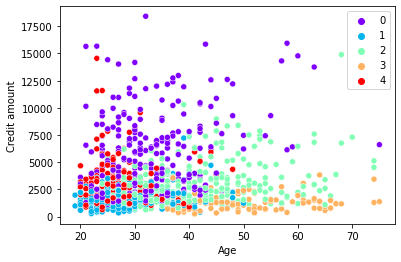

In [104]:
fig = plt.figure()
sns.scatterplot(x='Age', y='Credit amount', data=df, hue=labels, palette='rainbow')

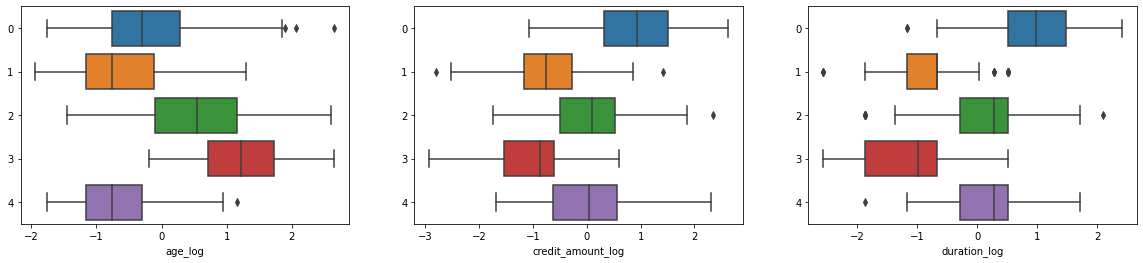

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax_index, col in enumerate(['age_log', 'credit_amount_log', 'duration_log']):
    sns.boxplot(data=data_scaled, x=col, y=labels, orient='h', ax=axes[ax_index])

In [106]:
plot_3d_on_original_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [107]:
plot_3d_on_scaled_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [108]:
df['labels'] = labels
df.groupby('labels').median().T.round(2)

labels,0,1,2,3,4
Age,31.00,27.00,40.00,49.00,27.00
Job,2.00,2.00,2.00,2.00,2.00
Credit amount,5014.50,1337.50,2600.00,1239.00,2478.00
Duration,31.50,12.00,21.00,10.00,21.00
age_log,3.43,3.30,3.69,3.89,3.30
credit_amount_log,8.52,7.20,7.86,7.12,7.82
duration_log,3.45,2.48,3.04,2.30,3.04


### 7 кластеров

In [109]:
agg = AgglomerativeClustering(n_clusters=7).fit(data_scaled)
labels = agg.labels_

<AxesSubplot:xlabel='P1', ylabel='P2'>

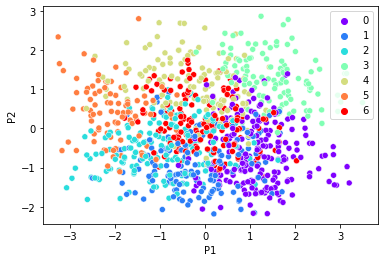

In [110]:
# Уменьшенная размерность

%matplotlib inline

sns.scatterplot(x='P1', y='P2', data=data_2d, hue=labels, palette='rainbow')

<AxesSubplot:xlabel='Age', ylabel='Credit amount'>

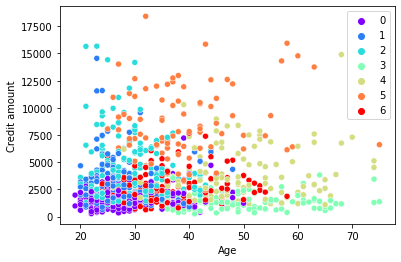

In [111]:
fig = plt.figure()
sns.scatterplot(x='Age', y='Credit amount', data=df, hue=labels, palette='rainbow')

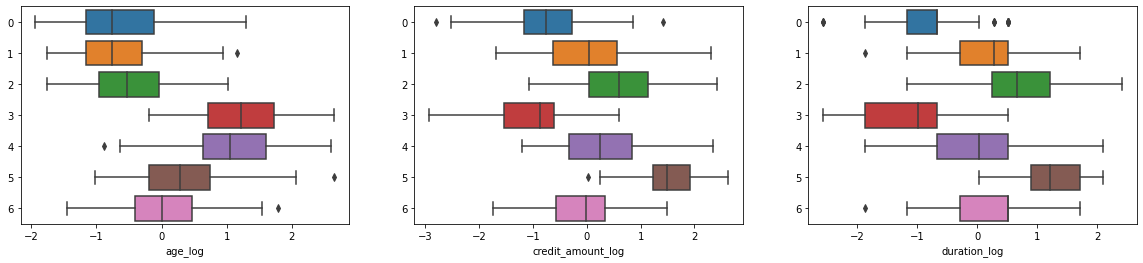

In [112]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax_index, col in enumerate(['age_log', 'credit_amount_log', 'duration_log']):
    sns.boxplot(data=data_scaled, x=col, y=labels, orient='h', ax=axes[ax_index])

In [114]:
plot_3d_on_original_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [115]:
plot_3d_on_scaled_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
df['labels'] = labels
df.groupby('labels').median().T.round(2)

### Агломеративная кластеризация справилась неплохо с разделением на 2, 3 и 6 кластеров, в остальном же она уступила KMeans

## DBSCAN

In [116]:
%matplotlib inline

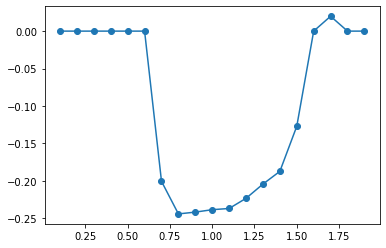

In [117]:
feature_range = np.arange(0.1, 2, 0.1)
silhouette, clusters = get_silhouette(DBSCAN, feature_range, 'eps')
plt.plot(feature_range, silhouette, marker='o')

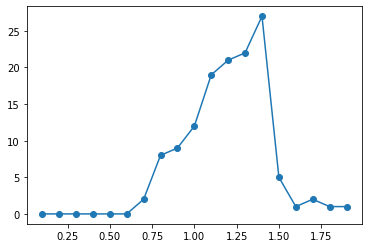

In [118]:
plt.plot(feature_range, clusters, marker='o')

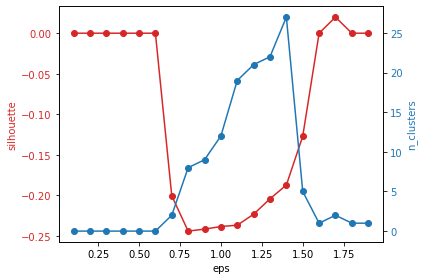

In [119]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(feature_range, silhouette, marker='o', color=color)
ax1.set_xlabel('eps')
ax1.set_ylabel('silhouette', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(feature_range, clusters, marker='o', color=color)
ax2.set_ylabel('n_clusters', color=color)  
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Судя по силуетному коэффициенту, необходимо взять eps = 1.5 или 1.7

### eps = 1.5

In [120]:
dbscan = DBSCAN(eps=1.5).fit(data_scaled)
labels = dbscan.labels_

<AxesSubplot:xlabel='P1', ylabel='P2'>

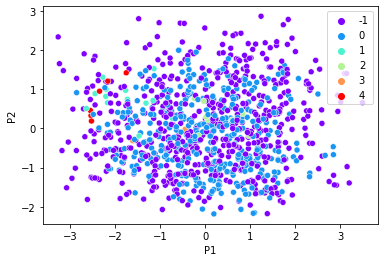

In [121]:
# Уменьшенная размерность

sns.scatterplot(x='P1', y='P2', data=data_2d, hue=labels, palette='rainbow')

<AxesSubplot:xlabel='Age', ylabel='Credit amount'>

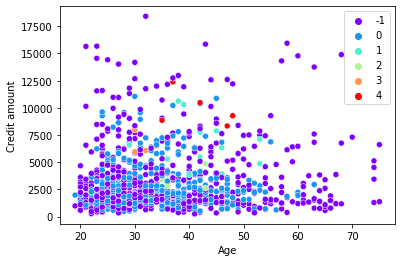

In [122]:
fig = plt.figure()
sns.scatterplot(x='Age', y='Credit amount', data=df, hue=labels, palette='rainbow')

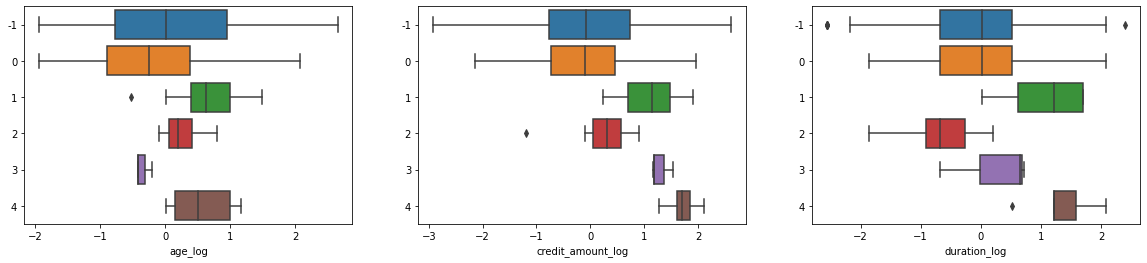

In [123]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax_index, col in enumerate(['age_log', 'credit_amount_log', 'duration_log']):
    sns.boxplot(data=data_scaled, x=col, y=labels, orient='h', ax=axes[ax_index])

In [124]:
plot_3d_on_original_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [125]:
plot_3d_on_scaled_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [126]:
df['labels'] = labels
df.groupby('labels').median().T.round(2)

labels,-1,0,1,2,3,4
Age,34.00,31.50,41.00,36.00,30.00,39.50
Job,2.00,2.00,2.50,2.00,2.00,2.00
Credit amount,2278.00,2243.50,5912.00,3092.50,6078.00,9067.50
Duration,18.00,18.00,36.00,12.00,26.00,36.00
age_log,3.53,3.45,3.71,3.58,3.40,3.67
credit_amount_log,7.73,7.72,8.68,8.03,8.71,9.11
duration_log,2.89,2.89,3.58,2.48,3.26,3.58


### eps = 1.7

In [127]:
dbscan = DBSCAN(eps=1.7).fit(data_scaled)
labels = dbscan.labels_

<AxesSubplot:xlabel='P1', ylabel='P2'>

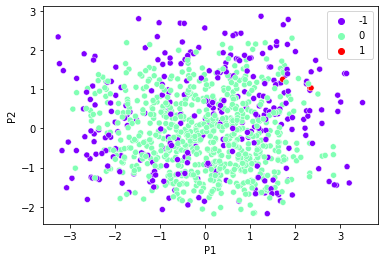

In [128]:
# Уменьшенная размерность

%matplotlib inline

sns.scatterplot(x='P1', y='P2', data=data_2d, hue=labels, palette='rainbow')

<AxesSubplot:xlabel='Age', ylabel='Credit amount'>

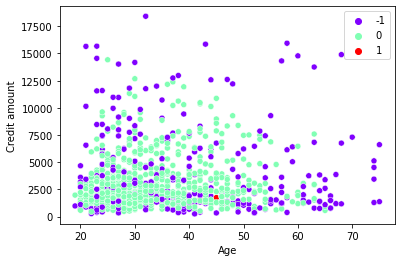

In [129]:
fig = plt.figure()
sns.scatterplot(x='Age', y='Credit amount', data=df, hue=labels, palette='rainbow')

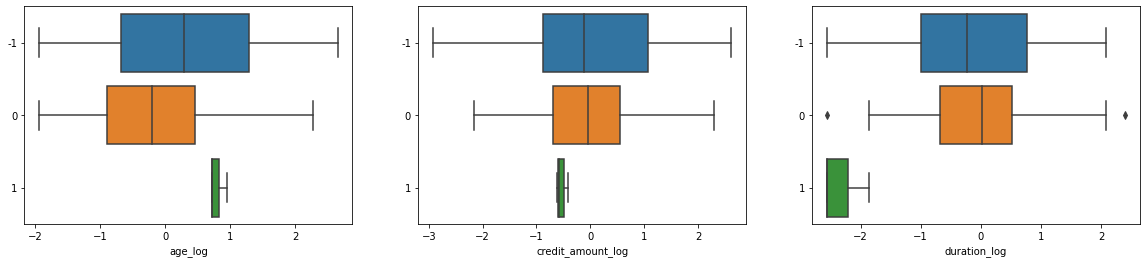

In [130]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
for ax_index, col in enumerate(['age_log', 'credit_amount_log', 'duration_log']):
    sns.boxplot(data=data_scaled, x=col, y=labels, orient='h', ax=axes[ax_index])

In [131]:
plot_3d_on_original_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [132]:
plot_3d_on_scaled_data(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [133]:
df['labels'] = labels
df.groupby('labels').median().T.round(2)

labels,-1,0,1
Age,37.00,32.00,42.00
Job,2.00,2.00,1.00
Credit amount,2205.50,2327.00,1544.00
Duration,15.50,18.00,4.00
age_log,3.61,3.47,3.74
credit_amount_log,7.70,7.75,7.34
duration_log,2.74,2.89,1.39


### Варьируя только eps, не получилось добиться результата, в основном все точки приняты за шум. Необходимо дополнительно проварьировать min_samples

In [134]:
silhouette = []
clusters = []
eps_range = np.arange(0.1, 2.1, 0.1)
min_samples_range = range(1, 11)
for i in eps_range:
    eps_silhouette = []
    eps_clusters = []
    for j in min_samples_range:
        clusterization = DBSCAN(eps=i, min_samples=j).fit(data_scaled)
        labels = clusterization.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(data_scaled, labels)
        else:
            score = 0
        eps_silhouette.append(score)
        eps_clusters.append(n_clusters)
    silhouette.append(eps_silhouette)
    clusters.append(eps_clusters)

In [135]:
len(silhouette)

20

In [136]:
%matplotlib inline

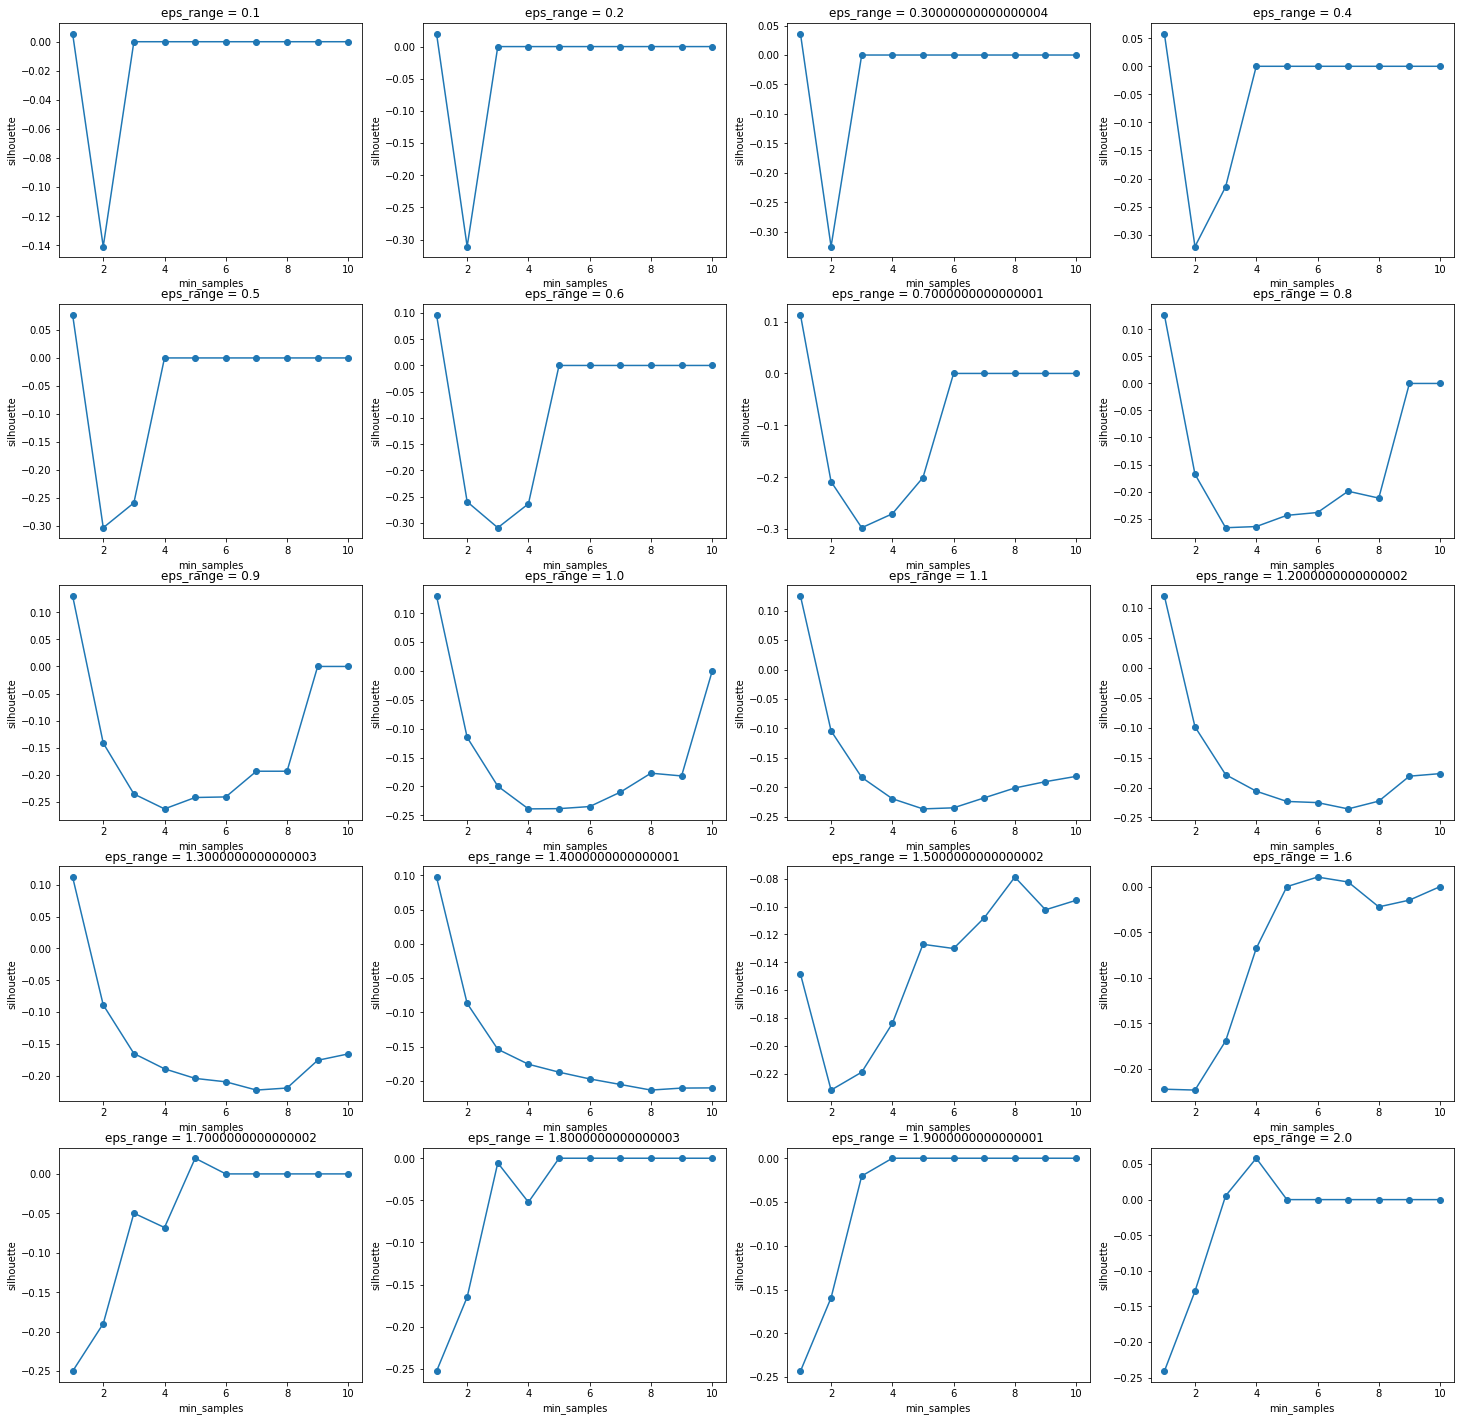

In [137]:
fig, axes = plt.subplots(5, 4, figsize=(25, 25))
silhouette_index = 0
for ax_x_index in range(0, 5):
    for ax_y_index in range(0, 4):
        axes[ax_x_index, ax_y_index].plot(min_samples_range, silhouette[silhouette_index], marker='o')
        axes[ax_x_index, ax_y_index].set_title(f'eps_range = {eps_range[silhouette_index]}')
        axes[ax_x_index, ax_y_index].set_xlabel('min_samples')
        axes[ax_x_index, ax_y_index].set_ylabel('silhouette')
        silhouette_index += 1

In [138]:
max_silhouette_values = [{'eps_range': eps_range[silhouette_index],
                          'min_samples': np.argmax(silhouette[silhouette_index]) + 1,
                          'max_silhouette_value': np.max(silhouette[silhouette_index])} for silhouette_index in range(len(silhouette))]
max_silhouette_values

[{'eps_range': 0.1,
  'min_samples': 1,
  'max_silhouette_value': 0.005622159495153772},
 {'eps_range': 0.2,
  'min_samples': 1,
  'max_silhouette_value': 0.020271073439563685},
 {'eps_range': 0.30000000000000004,
  'min_samples': 1,
  'max_silhouette_value': 0.03643915122864214},
 {'eps_range': 0.4,
  'min_samples': 1,
  'max_silhouette_value': 0.05835074076175305},
 {'eps_range': 0.5,
  'min_samples': 1,
  'max_silhouette_value': 0.07721797266388847},
 {'eps_range': 0.6,
  'min_samples': 1,
  'max_silhouette_value': 0.0966337451515201},
 {'eps_range': 0.7000000000000001,
  'min_samples': 1,
  'max_silhouette_value': 0.1130902763967841},
 {'eps_range': 0.8,
  'min_samples': 1,
  'max_silhouette_value': 0.1271858844249662},
 {'eps_range': 0.9,
  'min_samples': 1,
  'max_silhouette_value': 0.13010783103135648},
 {'eps_range': 1.0,
  'min_samples': 1,
  'max_silhouette_value': 0.1301650114328822},
 {'eps_range': 1.1,
  'min_samples': 1,
  'max_silhouette_value': 0.1250988656660068},
 {'e

In [140]:
max_silhouette_values_list = [x['max_silhouette_value'] for x in max_silhouette_values]

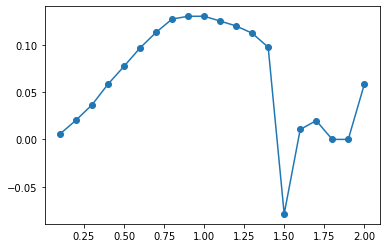

In [141]:
plt.plot(eps_range, max_silhouette_values_list, marker='o')

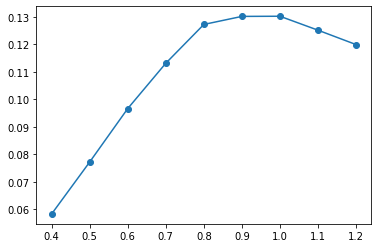

In [142]:
plt.plot(eps_range[3:12], max_silhouette_values_list[3:12], marker='o')

### Силуетный коэффициент достигает максимума при eps = 0.8, 0.9 и 1.0

In [144]:
max_silhouette_with_eps_and_min_samples = []
for x in max_silhouette_values:
    if x['eps_range'] in [0.8, 0.9, 1.0]:
        max_silhouette_with_eps_and_min_samples.append(x['min_samples'])

In [145]:
max_silhouette_with_eps_and_min_samples

[1, 1, 1]

In [146]:
dbscan = DBSCAN(eps=0.8, min_samples=1).fit(data_scaled)
labels = dbscan.labels_

<AxesSubplot:xlabel='P1', ylabel='P2'>

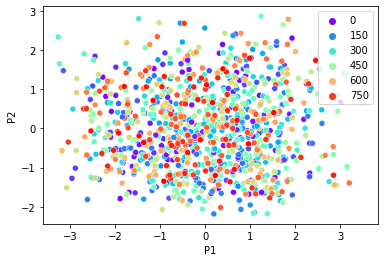

In [147]:
# Уменьшенная размерность

sns.scatterplot(x='P1', y='P2', data=data_2d, hue=labels, palette='rainbow')

In [148]:
dbscan = DBSCAN(eps=0.9, min_samples=1).fit(data_scaled)
labels = dbscan.labels_

<AxesSubplot:xlabel='P1', ylabel='P2'>

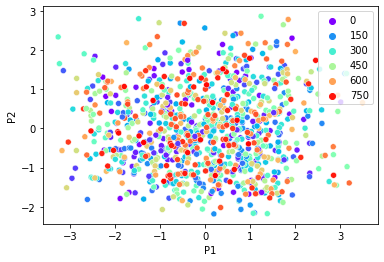

In [149]:
# Уменьшенная размерность

sns.scatterplot(x='P1', y='P2', data=data_2d, hue=labels, palette='rainbow')

In [150]:
dbscan = DBSCAN(eps=1.0, min_samples=1).fit(data_scaled)
labels = dbscan.labels_

<AxesSubplot:xlabel='P1', ylabel='P2'>

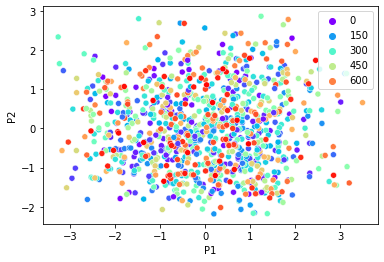

In [151]:
# Уменьшенная размерность

sns.scatterplot(x='P1', y='P2', data=data_2d, hue=labels, palette='rainbow')

### Во всех вариантах DBSCAN показал силуетный коэффициент не больше 0.13 и не смог справиться с задачей